In [1]:
!date

Mon Oct 28 17:02:06 EDT 2024


In [2]:
pwd

'/mmfs1/data/aglinska/BC-ABCD-denoise/Code'

In [3]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
import ants

/data/aglinska/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/data/aglinska/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/data/aglinska/anaconda3/lib/python3.8/site-packages/paramiko/transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [4]:
from nilearn.glm.first_level import make_first_level_design_matrix

/data/aglinska/.local/lib/python3.8/site-packages/nilearn/glm/__init__.py:55: FutureWarning:

The nilearn.glm module is experimental. It may change in any future release of Nilearn.



In [5]:
def correlate_columns(arr1, arr2):
    """
    Computes the Pearson correlation between corresponding columns of two matrices.
    
    Parameters:
    arr1 (np.ndarray): First matrix of shape (370, 1000)
    arr2 (np.ndarray): Second matrix of shape (370, 1000)
    
    Returns:
    np.ndarray: 1D array of correlations for each column (size 1000)
    """
    # Ensure input arrays are numpy arrays
    arr1 = np.asarray(arr1)
    arr2 = np.asarray(arr2)
    
    # Subtract the mean of each column (normalize)
    arr1_centered = arr1 - np.mean(arr1, axis=0)
    arr2_centered = arr2 - np.mean(arr2, axis=0)
    
    # Compute the numerator (covariance)
    numerator = np.sum(arr1_centered * arr2_centered, axis=0)
    
    # Compute the denominator (product of standard deviations)
    denominator = np.sqrt(np.sum(arr1_centered**2, axis=0) * np.sum(arr2_centered**2, axis=0))
    
    # Compute the Pearson correlation for each column
    correlation = numerator / denominator
    
    return correlation

In [6]:
indir = '../Data/020-fmriprepped/'

In [7]:
subs = [sub for sub in os.listdir(indir) if all((sub.startswith('sub-'),not sub.endswith('.html')))]
n_subs = len(subs)
print(n_subs)

34


In [8]:
# Cell tagged parameters
s = 7
r = 1
fileversion='deepcor-FG'

In [9]:
if fileversion=='deepcor-FG':
    sub = subs[s]
    epi_fn = '../Data/050-Data-DeepCor-ed/linear-200-epochs-fgreg-50/deepcor-FG-{sub}-run-{run}-rep-{rep}.nii.gz'
    epi_ims = [ants.image_read(epi_fn.format(sub=sub,run=r,rep=i)) for i in range(5)]
    epi_arr = np.array([im.numpy() for im in epi_ims]).mean(axis=0)
    epi = epi_ims[0].new_image_like(epi_arr)
    
    gm_fn = os.path.join(indir,'{sub}/ses-baselineYear1Arm1/anat/{sub}_ses-baselineYear1Arm1_run-01_space-MNI152NLin2009cAsym_res-2_label-GM_probseg.nii.gz')
    gm = ants.image_read(gm_fn.format(sub=sub))
    gm = gm>.5
else:
    sub = subs[s]
    epi_fn = os.path.join(indir,'{sub}/ses-baselineYear1Arm1/func/{sub}_ses-baselineYear1Arm1_task-nback_run-0{r}_space-MNI152NLin2009cAsym_res-2_desc-{fileversion}_bold.nii')
    gm_fn = os.path.join(indir,'{sub}/ses-baselineYear1Arm1/anat/{sub}_ses-baselineYear1Arm1_run-01_space-MNI152NLin2009cAsym_res-2_label-GM_probseg.nii.gz')
    epi = ants.image_read(epi_fn.format(sub=sub,r=r,fileversion=fileversion))
    gm = ants.image_read(gm_fn.format(sub=sub))
    gm = gm>.5

In [10]:
nt = epi.shape[-1] # Number of timepoints
ndummy = 8 # how many dummies to discard

epi_flat = epi.numpy().reshape(-1,nt).transpose() # (370, 1082035)
epi_flat[0:ndummy,:] = epi_flat[ndummy+1::,:].mean(axis=0) # What to do with dummy scans, set to mean
epi_flat = epi_flat.transpose()

In [11]:
gm_flat = gm.numpy().flatten().astype(int)

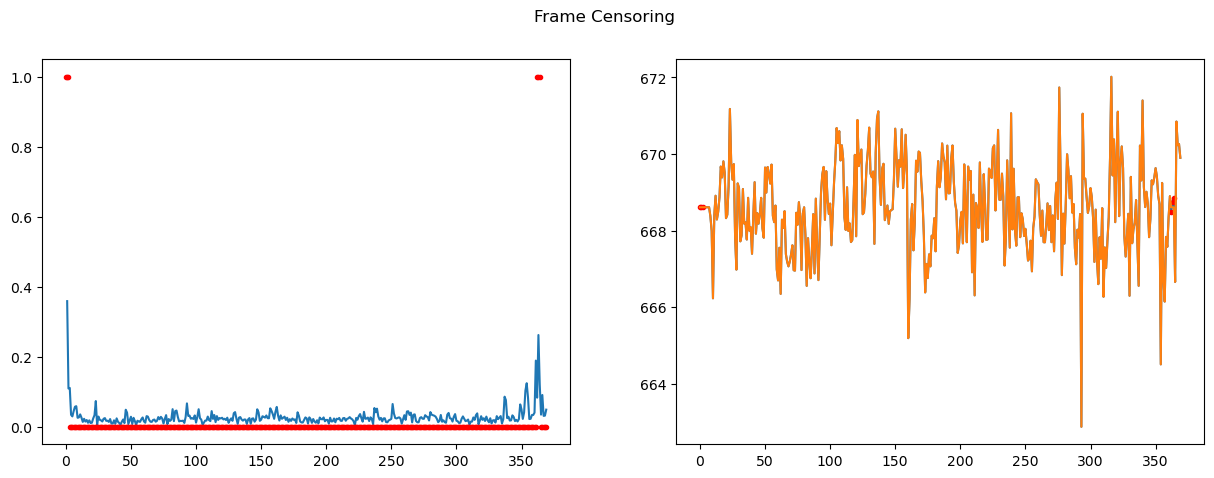

In [12]:
do_censor_frames=True
if do_censor_frames:
    mot_fn = f'../Data/020-fmriprepped/{sub}/ses-baselineYear1Arm1/func/{sub}_ses-baselineYear1Arm1_task-nback_run-0{r}_desc-confounds_timeseries.tsv'
    mot = pd.read_csv(mot_fn,delimiter='\t')
    mot_outliers = mot['framewise_displacement'].values>.2
    mot_outliers = np.vstack((mot_outliers,np.hstack((False,mot_outliers[0:-1])),np.hstack((mot_outliers[1::],False)))).sum(axis=0)>0
    outlier_idx = np.nonzero(mot_outliers)[0]
    
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(mot['framewise_displacement'].values)
    plt.plot(mot_outliers,'r.')
    
    plt.subplot(1,2,2)
    plot_vec = epi_flat[gm_flat==1,:][5000,:]
    outlier_idx = np.nonzero(mot_outliers)[0]
    plt.plot(plot_vec)
    plt.plot(outlier_idx,plot_vec[outlier_idx],'r.')
    
    plot_vec[mot_outliers] = plot_vec[~mot_outliers].mean()
    plt.plot(plot_vec)
    
    epi_flat[:,mot_outliers] = epi_flat[:,~mot_outliers].mean(axis=1)[:,np.newaxis]
    plt.suptitle('Frame Censoring')

In [13]:
events_fn = f'../Data/010-Data_bids2/{sub}/ses-baselineYear1Arm1/func/{sub}_ses-baselineYear1Arm1_task-nback_run-0{r}_events.tsv'
events = pd.read_csv(events_fn,delimiter='\t')

t_r = 0.8  # repetition time is 1 second
n_scans = epi.shape[-1]
frame_times = (np.arange(n_scans) * t_r)

X1 = make_first_level_design_matrix(frame_times,events,drift_model="polynomial",drift_order=3,hrf_model="SPM") #

face_reg = X1[['0_back_negface','0_back_neutface','0_back_posface','2_back_negface','2_back_neutface']].values.sum(axis=1)
place_reg = X1[['0_back_place','2_back_place']].values.sum(axis=1)

In [14]:
ffa_im = ants.image_read('../Misc/ffa_mask_resampled.nii')

In [15]:
corr2face_res = correlate_columns(epi_flat[gm_flat==1,:].transpose(),np.array([face_reg for _ in range(int(gm_flat.sum()))]).transpose())
corr2face_res[np.isnan(corr2face_res)]=0
corr2face_flat = np.zeros(epi_flat.shape[0])
corr2face_flat[gm_flat==1] = corr2face_res
corr2face_im = ffa_im.new_image_like(corr2face_flat.reshape(epi.shape[0:3]))
corr2face_im.to_filename(f'../Data/060-Corr2Reg-baseline/corr2face-{fileversion}-{sub}-run-{r}.nii')

/tmp/ipykernel_1480555/8112417.py:27: RuntimeWarning:

invalid value encountered in true_divide



In [16]:
corr2place_res = correlate_columns(epi_flat[gm_flat==1,:].transpose(),np.array([place_reg for _ in range(int(gm_flat.sum()))]).transpose())
corr2place_res[np.isnan(corr2place_res)]=0
corr2place_flat = np.zeros(epi_flat.shape[0])
corr2place_flat[gm_flat==1] = corr2place_res
corr2place_im = ffa_im.new_image_like(corr2place_flat.reshape(epi.shape[0:3]))
corr2place_im.to_filename(f'../Data/060-Corr2Reg-baseline/corr2place-{fileversion}-{sub}-run-{r}.nii')

/tmp/ipykernel_1480555/8112417.py:27: RuntimeWarning:

invalid value encountered in true_divide



In [17]:
(corr2face_im-corr2place_im).to_filename(f'../Data/060-Corr2Reg-baseline/corrDiff-{fileversion}-{sub}-run-{r}.nii')

In [18]:
(corr2face_im[ffa_im].mean(),corr2place_im[ffa_im].mean())

(0.100604884, -0.030664707)

In [19]:
(corr2face_im-corr2place_im)[ffa_im].mean()

0.13126959